In [ ]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json

# === Загрузка данных ===
flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

# === Параметры ===
NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
GENE_SIZE = 4  # [cycle, green_main, green_sec, offset]

# === Фитнес-функция ===
def fitness(ind):
    total_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        if not (constraints['min_cycle_sec'] <= cycle <= constraints['max_cycle_sec']):
            return (1e9,)
        if g_main < constraints['min_green_sec'] or g_sec < constraints['min_green_sec']:
            return (1e9,)
        if g_main < constraints['pedestrian_green_sec'] or g_sec < constraints['pedestrian_green_sec']:
            return (1e9,)
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        if not (0 <= offset <= cycle):
            return (1e9,)

        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share

            total_delay += (cycle - eff_green) * flow * weight

    penalty = 0.0
    absolute_arrival = ind[3]  

    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]

        absolute_arrival += TRAVEL_TIME
        expected = absolute_arrival % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)

    return (total_delay + 1000 * penalty,)

# === Инициализация DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * constraints['lost_time_sec_per_phase']
    for _ in range(NUM_INTERSECTIONS):
        c = random.randint(constraints['min_cycle_sec'], constraints['max_cycle_sec'])
        while True:
            g1 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            g2 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            if g1 + g2 + lost <= c:
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# === Запуск оптимизации ===
def run():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    algorithms.eaSimple(pop, toolbox,
                        cxpb=0.7, mutpb=0.3,
                        ngen=150, stats=stats,
                        halloffame=hof, verbose=True)

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)
    return best

# Подсчёт задержки автобусов по решению
def compute_bus_delay(solution):
    bus_delay = 0.0
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)

            delay = (cycle - eff_green) * flow_bus
            bus_delay += delay
    return bus_delay

if __name__ == "__main__":
    best_solution = run()
    bus_only_delay = compute_bus_delay(best_solution)
    print(f"🚌 Задержка по автобусным потокам: {bus_only_delay:,.2f} машино-секунд")


c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg   
0  	300   	359737	768246
1  	235   	408433	6.43571e+08
2  	221   	457267	6.66884e+08
3  	235   	457267	7.00199e+08
4  	228   	457267	6.50235e+08
5  	236   	457267	6.56903e+08
6  	230   	467668	6.10274e+08
7  	237   	495884	6.16928e+08
8  	233   	495884	5.56962e+08
9  	241   	476033	5.73612e+08
10 	248   	445303	5.46962e+08
11 	229   	445303	4.9365e+08 
12 	228   	445303	4.60334e+08
13 	234   	445303	4.30339e+08
14 	248   	431141	4.83632e+08
15 	248   	410950	5.20269e+08
16 	240   	411168	5.10274e+08
17 	238   	413000	4.9695e+08 
18 	227   	404773	4.6696e+08 
19 	239   	382138	4.46968e+08
20 	234   	382138	4.50292e+08
21 	229   	382138	4.20301e+08
22 	243   	398471	5.06913e+08
23 	241   	400274	4.56936e+08
24 	246   	388356	5.06904e+08
25 	233   	385056	4.40267e+08
26 	222   	376261	4.03613e+08
27 	234   	365000	4.33596e+08
28 	241   	372945	4.83571e+08
29 	231   	342384	4.36928e+08
30 	241   	374187	4.73575e+08
31 	239   	360060	4.53584e+08
32 	223   	360060	3.

In [ ]:
import pandas as pd
import json

# === Загрузка данных ===
signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

# План ДО оптимизации
plan_before = {
    int(row["intersection_id"]): {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"]
    } for _, row in signals_df.iterrows()
}

# План ПОСЛЕ оптимизации
plan_after = {
    i + 1: {
        "cycle": best[i * GENE_SIZE],
        "main": best[i * GENE_SIZE + 1],
        "sec": best[i * GENE_SIZE + 2]
    } for i in range(NUM_INTERSECTIONS)
}

# Функция расчёта среднего времени ожидания пешеходов
def pedestrian_wait_time(plan):
    total_wait = 0
    for node in plan:
        cycle = plan[node]["cycle"]
        ped_green = min(plan[node]["main"], plan[node]["sec"])  # предположение
        wait = cycle - ped_green
        total_wait += wait
    return total_wait / len(plan)

# Расчёты и вывод
wait_before = pedestrian_wait_time(plan_before)
wait_after = pedestrian_wait_time(plan_after)

print(f"🚶 Среднее ожидание пешеходов ДО оптимизации: {wait_before:.2f} сек")
print(f"🚦 Среднее ожидание пешеходов ПОСЛЕ оптимизации: {wait_after:.2f} сек")

🚶 Среднее ожидание пешеходов ДО оптимизации: 100.00 сек
🚦 Среднее ожидание пешеходов ПОСЛЕ оптимизации: 45.73 сек


In [96]:
import pandas as pd
import json

# === Загрузка данных ===
signals_df = pd.read_csv("signals_current.csv")
flows_df = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

# === Построение плана ДО оптимизации ===
signal_plan_before = {}
for _, row in signals_df.iterrows():
    inter_id = int(row["intersection_id"])
    signal_plan_before[inter_id] = {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"],
        "offset": 0,
        "abs_offset": 0
    }

# === Подсчёт задержки ===
def compute_total_delay(plan, flows, constraints):
    total = 0.0
    for inter_id, params in plan.items():
        df = flows[flows["intersection_id"] == inter_id]
        cycle = params["cycle"]
        g_main = params["main"]
        g_sec = params["sec"]
        for _, row in df.iterrows():
            is_main = row["approach"] in ["N", "S"]
            flow = row["intensity_veh_per_hr"]
            bus_share = row["bus_share"]
            green = g_main if is_main else g_sec
            bonus = constraints["min_extra_green_sec"]
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share
            total += (cycle - eff_green) * flow * weight
    return total

def compute_bus_delay(plan, flows, constraints):
    total = 0.0
    for inter_id, params in plan.items():
        df = flows[flows["intersection_id"] == inter_id]
        cycle = params["cycle"]
        g_main = params["main"]
        g_sec = params["sec"]
        for _, row in df.iterrows():
            is_main = row["approach"] in ["N", "S"]
            flow = row["intensity_veh_per_hr"]
            bus_share = row["bus_share"]
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints["min_extra_green_sec"]
            eff_green = min(cycle, green + bonus)
            total += (cycle - eff_green) * flow_bus
    return total

# === Выполнение расчёта ===
total_delay_before = compute_total_delay(signal_plan_before, flows_df, constraints)
bus_delay_before = compute_bus_delay(signal_plan_before, flows_df, constraints)

print(f"📊 Общая задержка ДО оптимизации: {total_delay_before:,.2f} машино-сек")
print(f"🚌 Задержка по автобусам ДО оптимизации: {bus_delay_before:,.2f} машино-сек")

📊 Общая задержка ДО оптимизации: 778,557.00 машино-сек
🚌 Задержка по автобусам ДО оптимизации: 44,028.50 машино-сек


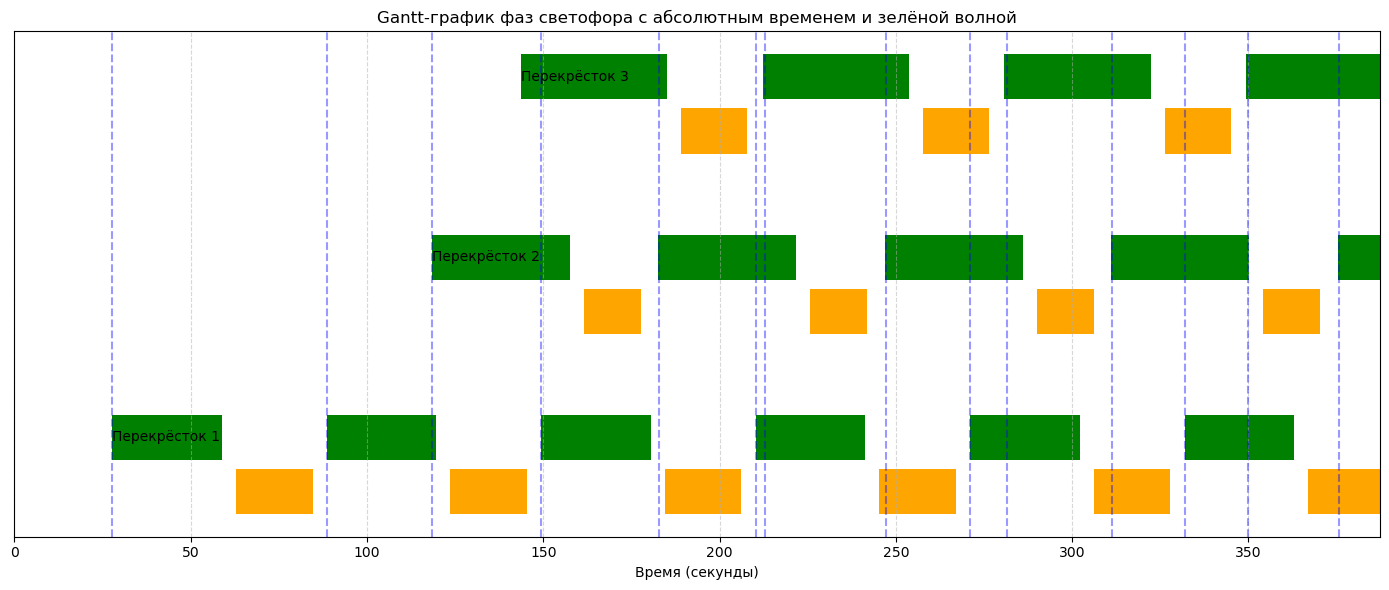

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры
plot_duration = sum(p['cycle'] for p in signal_plan.values()) * 2  # время отображения

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}

# Вычисляем накопленное время (сумму циклов) для каждого перекрёстка
time_accumulated = 0
time_accums = []
for i in range(1, NUM_INTERSECTIONS + 1):
    if i == 1:
        time_accumulated = 0
    else:
        time_accumulated += signal_plan[i - 1]['cycle']
    time_accums.append(time_accumulated)

for i, (inter_id, plan) in enumerate(signal_plan.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Рисуем несколько циклов главной фазы подряд
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Аналогично второстепенная фаза (начинается после main + lost_time)
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    # Рисуем линии прибытия транспорта (зелёная волна) для нескольких циклов
    # Рисуем линии прибытия транспорта (зелёная волна) для нескольких циклов
    for k in range(int(plot_duration // cycle) + 1):
        arrival = signal_plan[1]['abs_offset'] + TRAVEL_TIME * (inter_id - 1) + k * cycle + time_accums[i - 1]
        ax.axvline(arrival, color='blue', linestyle='--', alpha=0.4)


    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора с абсолютным временем и зелёной волной")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg   
0  	300   	361277	750285
1  	245   	361277	6.93532e+08
2  	245   	361277	7.83475e+08
3  	249   	368811	7.66819e+08
4  	241   	451329	7.93469e+08
5  	244   	423240	7.70152e+08
6  	234   	451329	7.36839e+08
7  	234   	444164	7.26846e+08
8  	238   	444164	7.13529e+08
9  	248   	444164	6.50245e+08
10 	222   	430194	5.8361e+08 
11 	232   	427985	5.46963e+08
12 	255   	407741	5.56954e+08
13 	252   	430194	5.40291e+08
14 	245   	428314	5.06978e+08
15 	242   	416848	4.57002e+08
16 	243   	416848	4.56996e+08
17 	240   	416848	3.97019e+08
18 	246   	399016	3.80346e+08
19 	236   	419312	4.66952e+08
20 	241   	419312	3.73662e+08
21 	249   	390460	4.36953e+08
22 	244   	393498	3.93638e+08
23 	243   	393498	3.7697e+08 
24 	229   	401191	3.50309e+08
25 	228   	392399	3.33646e+08
26 	249   	376129	3.90282e+08
27 	249   	362557	4.00274e+08
28 	253   	367514	3.8028e+08 
29 	250   	351766	3.46958e+08
30 	240   	351766	3.56951e+08
31 	231   	351766	3.70274e+08
32 	239   	351766	3.

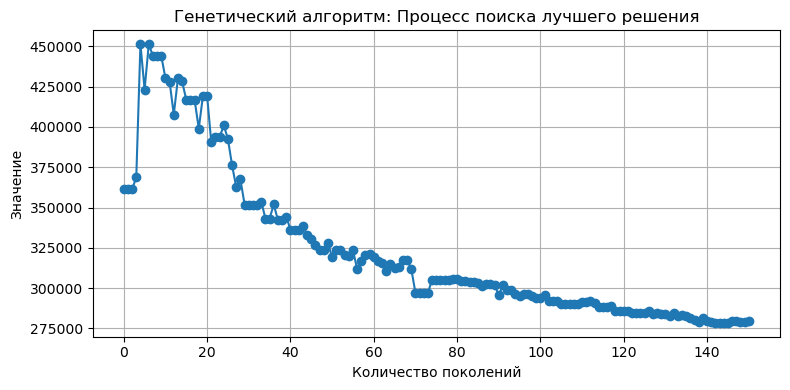

: 

In [ ]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json
import matplotlib.pyplot as plt

# === Загрузка данных ===
flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

# === Параметры ===
NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
GENE_SIZE = 4  # [cycle, green_main, green_sec, offset]

# === Фитнес-функция ===
def fitness(ind):
    total_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        # Проверка ограничений
        if not (constraints['min_cycle_sec'] <= cycle <= constraints['max_cycle_sec']):
            return (1e9,)
        if g_main < constraints['min_green_sec'] or g_sec < constraints['min_green_sec']:
            return (1e9,)
        if g_main < constraints['pedestrian_green_sec'] or g_sec < constraints['pedestrian_green_sec']:
            return (1e9,)
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        if not (0 <= offset <= cycle):
            return (1e9,)

        # Задержка по всем потокам с приоритетом автобусов
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share

            total_delay += (cycle - eff_green) * flow * weight

    # Координация (зелёная волна) с умеренным штрафом
    penalty = 0.0
    absolute_arrival = ind[3]  # offset первого перекрёстка

    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]

        absolute_arrival += TRAVEL_TIME
        expected = absolute_arrival % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)

    return (total_delay + 1000 * penalty,)

# === Инициализация DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * constraints['lost_time_sec_per_phase']
    for _ in range(NUM_INTERSECTIONS):
        c = random.randint(constraints['min_cycle_sec'], constraints['max_cycle_sec'])
        while True:
            g1 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            g2 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            if g1 + g2 + lost <= c:
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# === Запуск оптимизации с логированием ===
def run_with_stats():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    _, logbook = algorithms.eaSimple(pop, toolbox,
                        cxpb=0.7, mutpb=0.3,
                        ngen=150, stats=stats,
                        halloffame=hof, verbose=True)

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)

    return logbook

# === Вызов оптимизации и построение графика ===
logbook = run_with_stats()

gens = logbook.select("gen")       # список поколений [0, 1, 2, …]
best_vals = logbook.select("min")  # лучшая (минимальная) ценность фитнеса на каждом поколении

plt.figure(figsize=(8, 4))
plt.plot(gens, best_vals, marker="o", linestyle="-")
plt.title("Генетический алгоритм: Процесс поиска лучшего решения")
plt.xlabel("Количество поколений")
plt.ylabel("Значение")
plt.grid(True)
plt.tight_layout()
plt.show()
